In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import os
DEBUG=False

In [3]:
%run ./nb_core/root_dirs.ipynb
setup_syspath_disentangle(DEBUG)
%run ./nb_core/disentangle_imports.ipynb

DATA_ROOT:	 /group/jug/ashesh/data/
CODE_ROOT:	 /home/ashesh.ashesh/


In [4]:
from denoisplit.configs.sox2golgi_config import get_config
from denoisplit.core.model_type import ModelType
from denoisplit.core.data_split_type import DataSplitType
from denoisplit.data_loader.multifile_dset import MultiFileDset

config = get_config()
datapath = '/group/jug/ashesh/data/TavernaSox2Golgi/'

normalized_input = config.data.normalized_input
use_one_mu_std = config.data.use_one_mu_std
train_aug_rotate = config.data.train_aug_rotate
enable_random_cropping = config.data.deterministic_grid is False
lowres_supervision = config.model.model_type == ModelType.LadderVAEMultiTarget

train_data_kwargs = {}
val_data_kwargs = {}
train_data_kwargs['enable_random_cropping'] = enable_random_cropping
val_data_kwargs['enable_random_cropping'] = False
padding_kwargs = None
if 'multiscale_lowres_count' in config.data and config.data.multiscale_lowres_count is not None:
    padding_kwargs = {'mode': config.data.padding_mode}
if 'padding_value' in config.data and config.data.padding_value is not None:
    padding_kwargs['constant_values'] = config.data.padding_value

train_data = MultiFileDset(config.data,
                            datapath,
                            datasplit_type=DataSplitType.Train,
                            val_fraction=config.training.val_fraction,
                            test_fraction=config.training.test_fraction,
                            normalized_input=normalized_input,
                            use_one_mu_std=use_one_mu_std,
                            enable_rotation_aug=train_aug_rotate,
                            padding_kwargs=padding_kwargs,
                            **train_data_kwargs)

max_val = train_data.get_max_val()
val_data = MultiFileDset(
    config.data,
    datapath,
    datasplit_type=DataSplitType.Val,
    val_fraction=config.training.val_fraction,
    test_fraction=config.training.test_fraction,
    normalized_input=normalized_input,
    use_one_mu_std=use_one_mu_std,
    enable_rotation_aug=False,  # No rotation aug on validation
    padding_kwargs=padding_kwargs,
    max_val=max_val,
    **val_data_kwargs,
)

mean_val, std_val = train_data.compute_mean_std()
train_data.set_mean_std(mean_val, std_val)
val_data.set_mean_std(mean_val, std_val)


Loaded from OneChannel /group/jug/ashesh/data/TavernaSox2Golgi/ 121
[SingleFileDset] Sz:64 Train:1 N:1 NumPatchPerN:256 NormInp:True SingleNorm:True Rot:False RandCrop:True Q:0.995 SummedInput:False ReplaceWithRandSample:False BckQ:0.0
MultiFileDset avg height: 1024, avg width: 1024, count: 121
Loaded from OneChannel /group/jug/ashesh/data/TavernaSox2Golgi/ 15
[SingleFileDset] Sz:64 Train:0 N:1 NumPatchPerN:256 NormInp:True SingleNorm:True Rot:False RandCrop:False Q:0.995 SummedInput:False ReplaceWithRandSample:False BckQ:0.0
MultiFileDset avg height: 1024, avg width: 1024, count: 15


In [5]:
inp, tar = val_data[0]

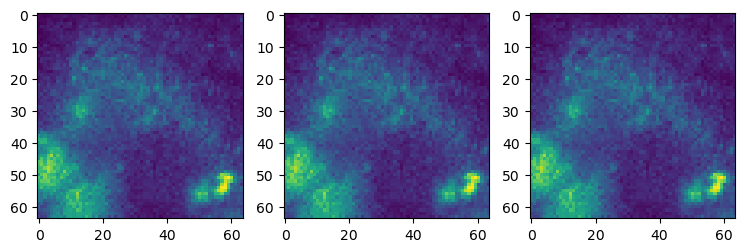

In [6]:
_,ax = plt.subplots(figsize=(9,3),ncols=3)
ax[0].imshow(inp[0])
ax[1].imshow(tar[0])
ax[2].imshow(tar[1])

In [7]:
inp.shape

(1, 64, 64)

In [8]:
inp_arr = []
for i in range(len(val_data)):
    inp, tar = val_data[i]
    inp_arr.append(inp)

In [9]:
inpdata= np.concatenate(inp_arr,axis=0)

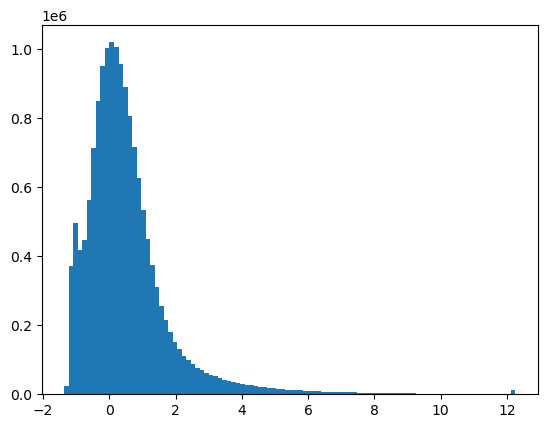

In [10]:
import matplotlib.pyplot as plt
_ = plt.hist(inpdata.flatten(),bins=100)

In [11]:
# import seaborn as sns
# sns.histplot(inpdata.flatten(),bins=100)

In [12]:
np.quantile(inpdata,[0.0, 0.01, 0.1, 0.5, 0.99,1])

array([-1.35542893, -1.1493119 , -0.72831666,  0.27736855,  6.13533545,
       12.25567436])

In [14]:
# config.data


In [19]:
from denoisplit.data_loader.sox2golgi_rawdata_loader import (get_train_val_data, get_one_channel_files, get_two_channel_files, SubDsetType)
datadir = '/group/jug/ashesh/data/TavernaSox2Golgi/'

config.data.subdset_type = SubDsetType.TwoChannel
data2ch = get_train_val_data(datadir,
                       config.data,
                       DataSplitType.Test,
                       val_fraction=0.1,
                       test_fraction=0.1)

config.data.subdset_type = SubDsetType.OneChannel
data1ch = get_train_val_data(datadir,
                       config.data,
                       DataSplitType.Test,
                       val_fraction=0.1,
                       test_fraction=0.1)

Loaded from TwoChannel /group/jug/ashesh/data/TavernaSox2Golgi/ 8
Loaded from OneChannel /group/jug/ashesh/data/TavernaSox2Golgi/ 15


In [20]:
len(data1ch), len(data2ch)

(15, 8)

In [34]:
import numpy as np
input1ch = []
input2ch = []
for idx in range(len(data1ch)):
    input1ch.append(np.mean(data1ch[idx][0],axis=2, keepdims=True))

for idx in range(len(data2ch)):
    input2ch.append(np.mean(data2ch[idx][0],axis=2, keepdims=True))

input1ch = np.concatenate(input1ch,axis=-1)
input2ch = np.concatenate(input2ch,axis=-1)

/home/ashesh.ashesh/mambaforge/envs/usplit/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ashesh.ashesh/mambaforge/envs/usplit/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/ashesh.ashesh/mambaforge/envs/usplit/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ashesh.ashesh/mambaforge/envs/usplit/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is de

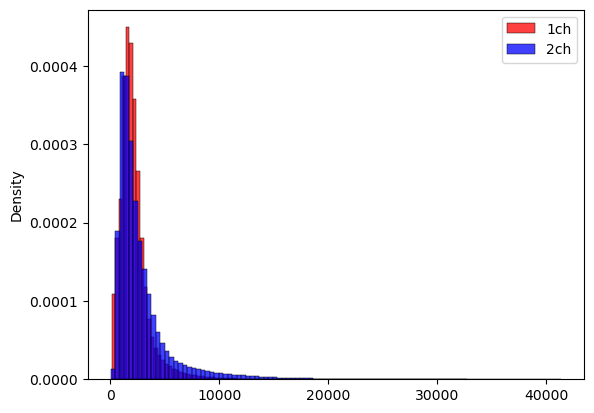

In [46]:
import seaborn as sns
_,ax = plt.subplots()
sns.histplot(input1ch.flatten()/2,bins=100, color='red', label='1ch', stat='density')
sns.histplot(input2ch.flatten(),bins=100, color='blue', label='2ch', stat='density')
ax.legend()

In [48]:
print('input 1ch', np.quantile(input1ch/2,[0.0, 0.01, 0.1, 0.5, 0.9, 0.99,1]).astype(np.int32))
print('input 2ch', np.quantile(input2ch,[0.0, 0.01, 0.1, 0.5, 0.9, 0.99,1]).astype(np.int32))

input 1ch [  122   340   808  1883  3576  8184 32767]
input 2ch [   36   522   912  1989  5595 14644 41394]


In [37]:
ch1 = []
ch2 = []
for idx in range(len(data2ch)):
    tmpd = data2ch[idx][0]
    ch1.append(tmpd[:,:,:1])
    ch2.append(tmpd[:,:,1:])

ch1 = np.concatenate(ch1,axis=-1)
ch2 = np.concatenate(ch2,axis=-1)

/home/ashesh.ashesh/mambaforge/envs/usplit/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ashesh.ashesh/mambaforge/envs/usplit/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/ashesh.ashesh/mambaforge/envs/usplit/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ashesh.ashesh/mambaforge/envs/usplit/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is de

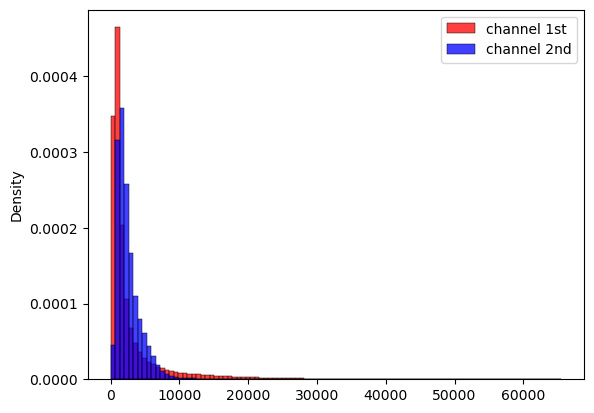

In [38]:
_,ax = plt.subplots()
sns.histplot(ch1.flatten(),bins=100, color='red', label='channel 1st', stat='density')
sns.histplot(ch2.flatten(),bins=100, color='blue', label='channel 2nd', stat='density')
ax.legend()

In [45]:
print('channel 1', np.quantile(ch1,[0.0, 0.01, 0.1, 0.5, 0.99,1]).astype(np.int32))
print('channel 2', np.quantile(ch2,[0.0, 0.01, 0.1, 0.5, 0.99,1]).astype(np.int32))

channel 1 [    0   193   448  1208 25832 65535]
channel 2 [   32   533   967  2092  9282 65535]
